# Table of Contents

1. [Import Packages](#import-packages)
2. [Import Mouse Metadata](#import-mouse-metadata)
3. [Import Combined DLC CSV](#import-combined-dlc-csv)
4. [Create time-binned dictionary](##create-time-binned-dictionary)
5. [Exclusion Criteria](#exclusion-criteria)
6. [Plot 1: Heatmap Representations](#plot-1-heatmap-representations)
7. [Shannon's Entropy](#shannons-entropy)
<br>&nbsp;&nbsp;&nbsp;&nbsp;7.1. [Plot 2: Plotting Shannon's Entropy across Sessions](#plot-2-plotting-shannons-entropy-across-sessions-mice)
8. [Proportion of Region-based usage across Time bins](#proportion-of-region-based-usage-across-time-bins)
<br>&nbsp;&nbsp;&nbsp;&nbsp;8.1. [Plot 3: Proportion of usage per Region across time](#plot-3-proportion-of-usage-per-region-across-time)
<br>&nbsp;&nbsp;&nbsp;&nbsp;8.2. [Plot 4: Proportion of usage across all Regions](#plot-4-proportion-of-usage-across-all-regions)
9. [Bout-Level Success metrics](#bout-level-success-metrics)
<br>&nbsp;&nbsp;&nbsp;&nbsp;9.1. [Plot 5: Cumulative Successful Bout Percentage](#plot-5-cumulative-successful-bout-percentage)
<br>&nbsp;&nbsp;&nbsp;&nbsp;9.2. [Plot 6: Time-based Successful Bout Percentage](#plot-6-time-based-successful-bout-percentage)
11. [Plot 7: Deviation from Reward Path & Velocity Analysis ](#plot-7-deviation-from-reward-path-and-velocity)
<br>&nbsp;&nbsp;&nbsp;&nbsp;10.1. [Deviation from Reward Path and Velocity for all Genotypes](#deviation-from-reward-path-and-velocity-for-all-genotypes)

# Import Packages

In [1]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# autoreload (mainly for testing purposes)
%load_ext autoreload
%autoreload 2

In [ ]:
CUSTOM_UTILS_PATH = Path(os.getcwd()).parent/'src'/'behavior'/'behavior_metrics'/'task_performance_analysis'
if CUSTOM_UTILS_PATH.exists():
    sys.path.append(str(CUSTOM_UTILS_PATH))
    # Import custom analysis modules
    try:
        import performance_metrics
        from performance_metrics import *
        import success_metrics
        from success_metrics import *
        import trajectory_analysis
        from trajectory_analysis import *
        print("Utils loaded successfully!")
    except ImportError as e:
        print(f"Warning: Could not import custom modules: {e}")
else:
    print(f"Warning: Custom utils path not found: {CUSTOM_UTILS_PATH}")


import init_config
from init_config import *

import notebook_utils
from notebook_utils import *


Utils loaded successfully!
Location of Computer 1 Videos: 
Location of Computer 2 Videos: 
Central Video Location: c:\Users\PalopLabPortal\Gladstone Dropbox\Shreya Bangera\Labyrinth Mazes discussions\Code\TEST_COMPASS\videos\original_videos
DLC Scorer: DLC_resnet50_LabyrinthMar13shuffle1_1000000
Tracking bodyparts: nose, belly, sternum, leftflank, rightflank, tailbase
Experimental groups: ['A', 'B', 'C', 'D']


In [4]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42

# Import Project Folder Structure

In [ ]:
# =============================================================================
# CREATE PROJECT DIRECTORY AND SUBFOLDERS FROM CONFIG FILE
# =============================================================================
from init_config import *

print()
print(f'base_path: {BASE_PATH}')
DIRS = create_organized_directory_structure(BASE_PATH)

# Import Mouse Metadata

In [5]:
# Read in mouse metadata file
mouseinfo = pd.read_excel(os.path.join(METADATA_PATH,METADATA_FILE), sheet_name=TRIAL_TYPE)
print('Metadata columns: ',mouseinfo.columns)

# Consider only non-NA Sessions
mouseinfo = mouseinfo[~mouseinfo['Session #'].isna()]

# Find the subset of trials need to be excluded
mouseinfo = mouseinfo.loc[mouseinfo['Exclude Trial']!= 'yes'].reset_index(drop=True)

Metadata columns:  Index(['Session #', 'Run Date', 'Time Of Day', 'Rack Location', 'Computer',
       'Noldus Chamber', 'Camera #', 'Noldus Trial', 'Noldus Project Name',
       'DSI Trial', 'ID', 'Name', 'Sex', 'Status', 'Line', 'Genotype',
       'GenotypeOG', 'Birth Date', 'Age (months)', 'Housing ID',
       'Transmitter #', 'Exclude Trial', 'X1', 'X2', 'Y1', 'Y2', 'NOTES'],
      dtype='object')


# Import Combined DLC CSV

In [6]:
df_all_csv = pd.read_csv(os.path.join(BASE_PATH,'csvs','combined','Preprocessed_combined_file.csv'))

# Create Time-Binned Dictionary

In [7]:
# =================== USAGE EXAMPLE =================== #
# This workflow bins data from each session into defined intervals
# and calculates normalized region occupancy for each genotype. Each pivot table
# summarizes the proportion of time spent in each region across all sessions for a given bin.

# Recommended Use:
# ---------------
# 1. Ensure `df_all_csv` contains 'Session', 'Genotype', and 'Region' columns.
# 2. Set `LOWER_LIMIT` and `UPPER_LIMIT` to define the full range of timepoints to analyze.
# 3. Set `BIN_SIZE` (used as `difference`) to determine the duration of each bin (e.g., 10000).
# 4. Provide `region_lengths` as a dictionary mapping region names to their total grid lengths.
# 5. The function returns a dictionary of pivot tables (one per genotype), useful for heatmap plotting.

# Example Workflow:
# -----------------

#--------------- SET THESE VALUES --------------#
BIN_SIZE = 10000       # Bin width in timepoints   #x-axis bin size used to plot shannons entropy
LOWER_LIMIT = 0        # Start of time window
UPPER_LIMIT = 80000    # End of time window

#________________________________________________________
# Generate pivot tables for each genotype and time bin
pivot_dict = generate_region_heatmap_pivots(
    df_all_csv,
    lower_lim=LOWER_LIMIT,
    upper_lim=UPPER_LIMIT,
    difference=BIN_SIZE,
    region_lengths=region_lengths
)


# Exclusion Criteria

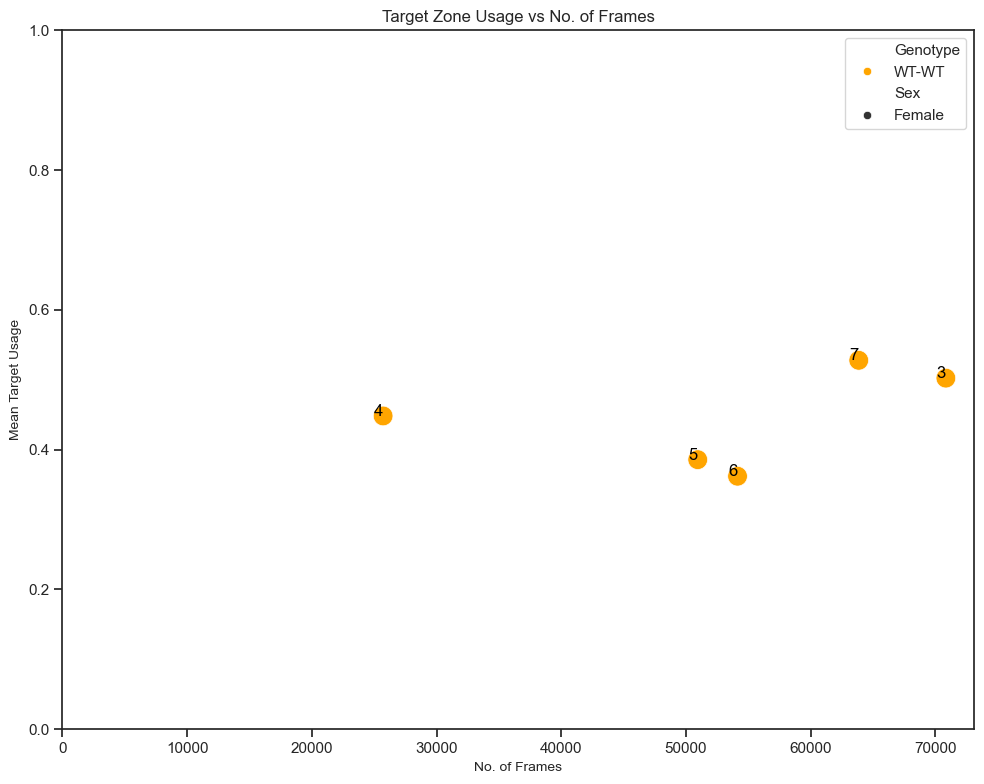

Invalid input. Using default thresholds: Target Usage = 0.4, Frames = 30000

Excluding 0 session(s): []


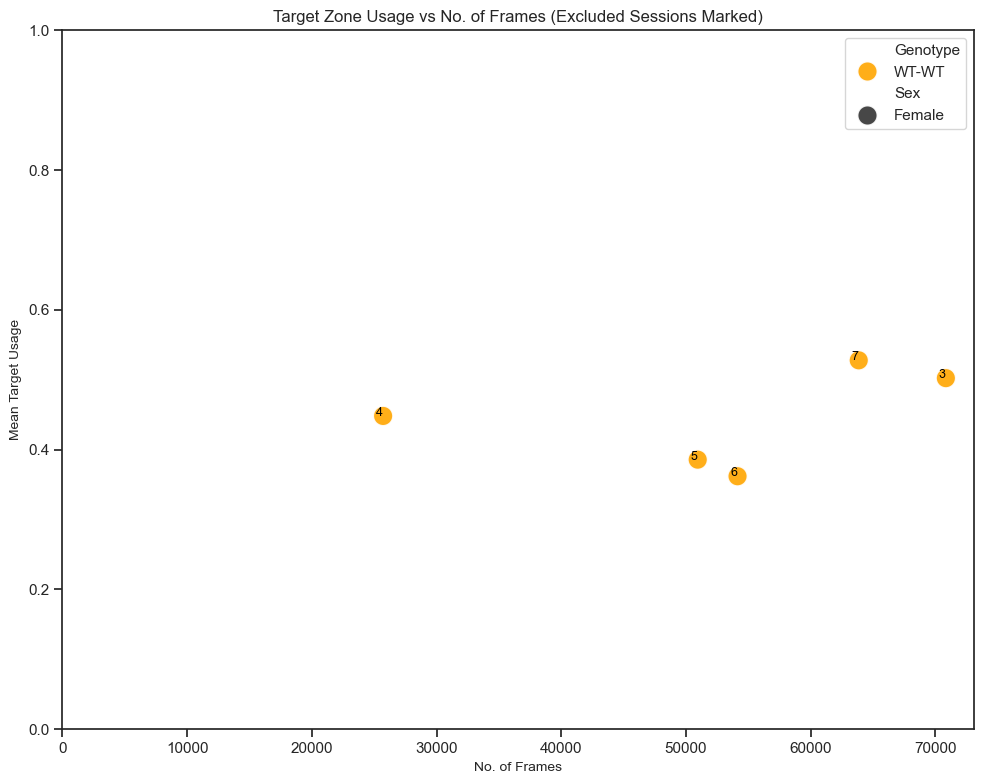

In [33]:
# =================== USAGE EXAMPLE =================== #
# This workflow quantifies target zone engagement across bouts and sessions, 
# plots the relationship between target usage and session duration, and 
# interactively excludes low-performing sessions based on user-defined thresholds.

# Recommended Use:
# ---------------
# 1. Ensure `df_all_csv` contains 'Session', 'Genotype', 'Grid.Number', and 'Bout_Index' columns.
# 2. Run `compute_frames_per_session()` to get the number of frames per session.
# 3. Use `compute_target_zone_usage()` to calculate per-bout usage for a specified region; set `region` and `difference` accordingly.
# 4. Summarize target usage at the session level using `summarize_target_usage()` with `mouseinfo` to add sex/genotype metadata.
# 5. Visualize the relationship between number of frames and target usage using `plot_target_usage_vs_frames()`.
# 6. Call `exclude_low_performing_sessions()` to interactively remove sessions below usage and duration thresholds.

# Example Workflow:
# -----------------

#--------------- SET THESE VALUES --------------#
BIN_SIZE = BIN_SIZE        # BASED ON THE TIME-BINNED DICTIONARY
REGION = "Target Zone"  # Region to evaluate usage
TARGET_REGION = "Target Zone"

#________________________________________________________
# Step 1: Total frames per session
frames_df = compute_frames_per_session(df_all_csv)

# Step 2: Target zone usage per bout
region_target = compute_target_zone_usage(
    df_all_csv,
    pivot_dict,
    region=REGION,
    difference=BIN_SIZE
)

# Step 3: Session-level summary
region_summary = summarize_target_usage(
    region_target,
    frames_df,
    mouseinfo
)

# Step 4: Visualize usage vs. session duration
plot_target_usage_vs_frames(region_summary)


# Step 5: Interactive exclusion based on usage and frame thresholds
df_all_csv = exclude_low_performing_sessions(
    df_all_csv,
    region_summary
)

# Step 6: Replot the target usage v/s frames plot with the excluded sessions 'X' out
sessions_to_exclude = region_summary.loc[
    ~region_summary['Session'].isin(df_all_csv['Session'])
]['Session'].tolist()

plot_target_usage_with_exclusions(region_summary, sessions_to_exclude)

# Save new preprocessed csv post exclusions

In [34]:
# Define path to the 'csvs' folder and final output file
csv_dir = os.path.join(BASE_PATH, 'csvs','combined')
output_file = os.path.join(csv_dir, 'Preprocessed_combined_file_exclusions.csv')

# Ensure the 'csvs' directory exists
os.makedirs(csv_dir, exist_ok=True)

# Save the DataFrame
df_all_csv.to_csv(output_file, index=False)

# Subset the Time-Binned Dictionary based on Valid Sessions

In [35]:
pivot_dict = subset_pivot_dict_sessions(pivot_dict, df_all_csv)

# Plot 1: Heatmap Representations

Saved: c:\Users\PalopLabPortal\Gladstone Dropbox\Shreya Bangera\Labyrinth Mazes discussions\Code\TEST_COMPASS\results/task_performance\WT-WT_Heatmap_representation.pdf


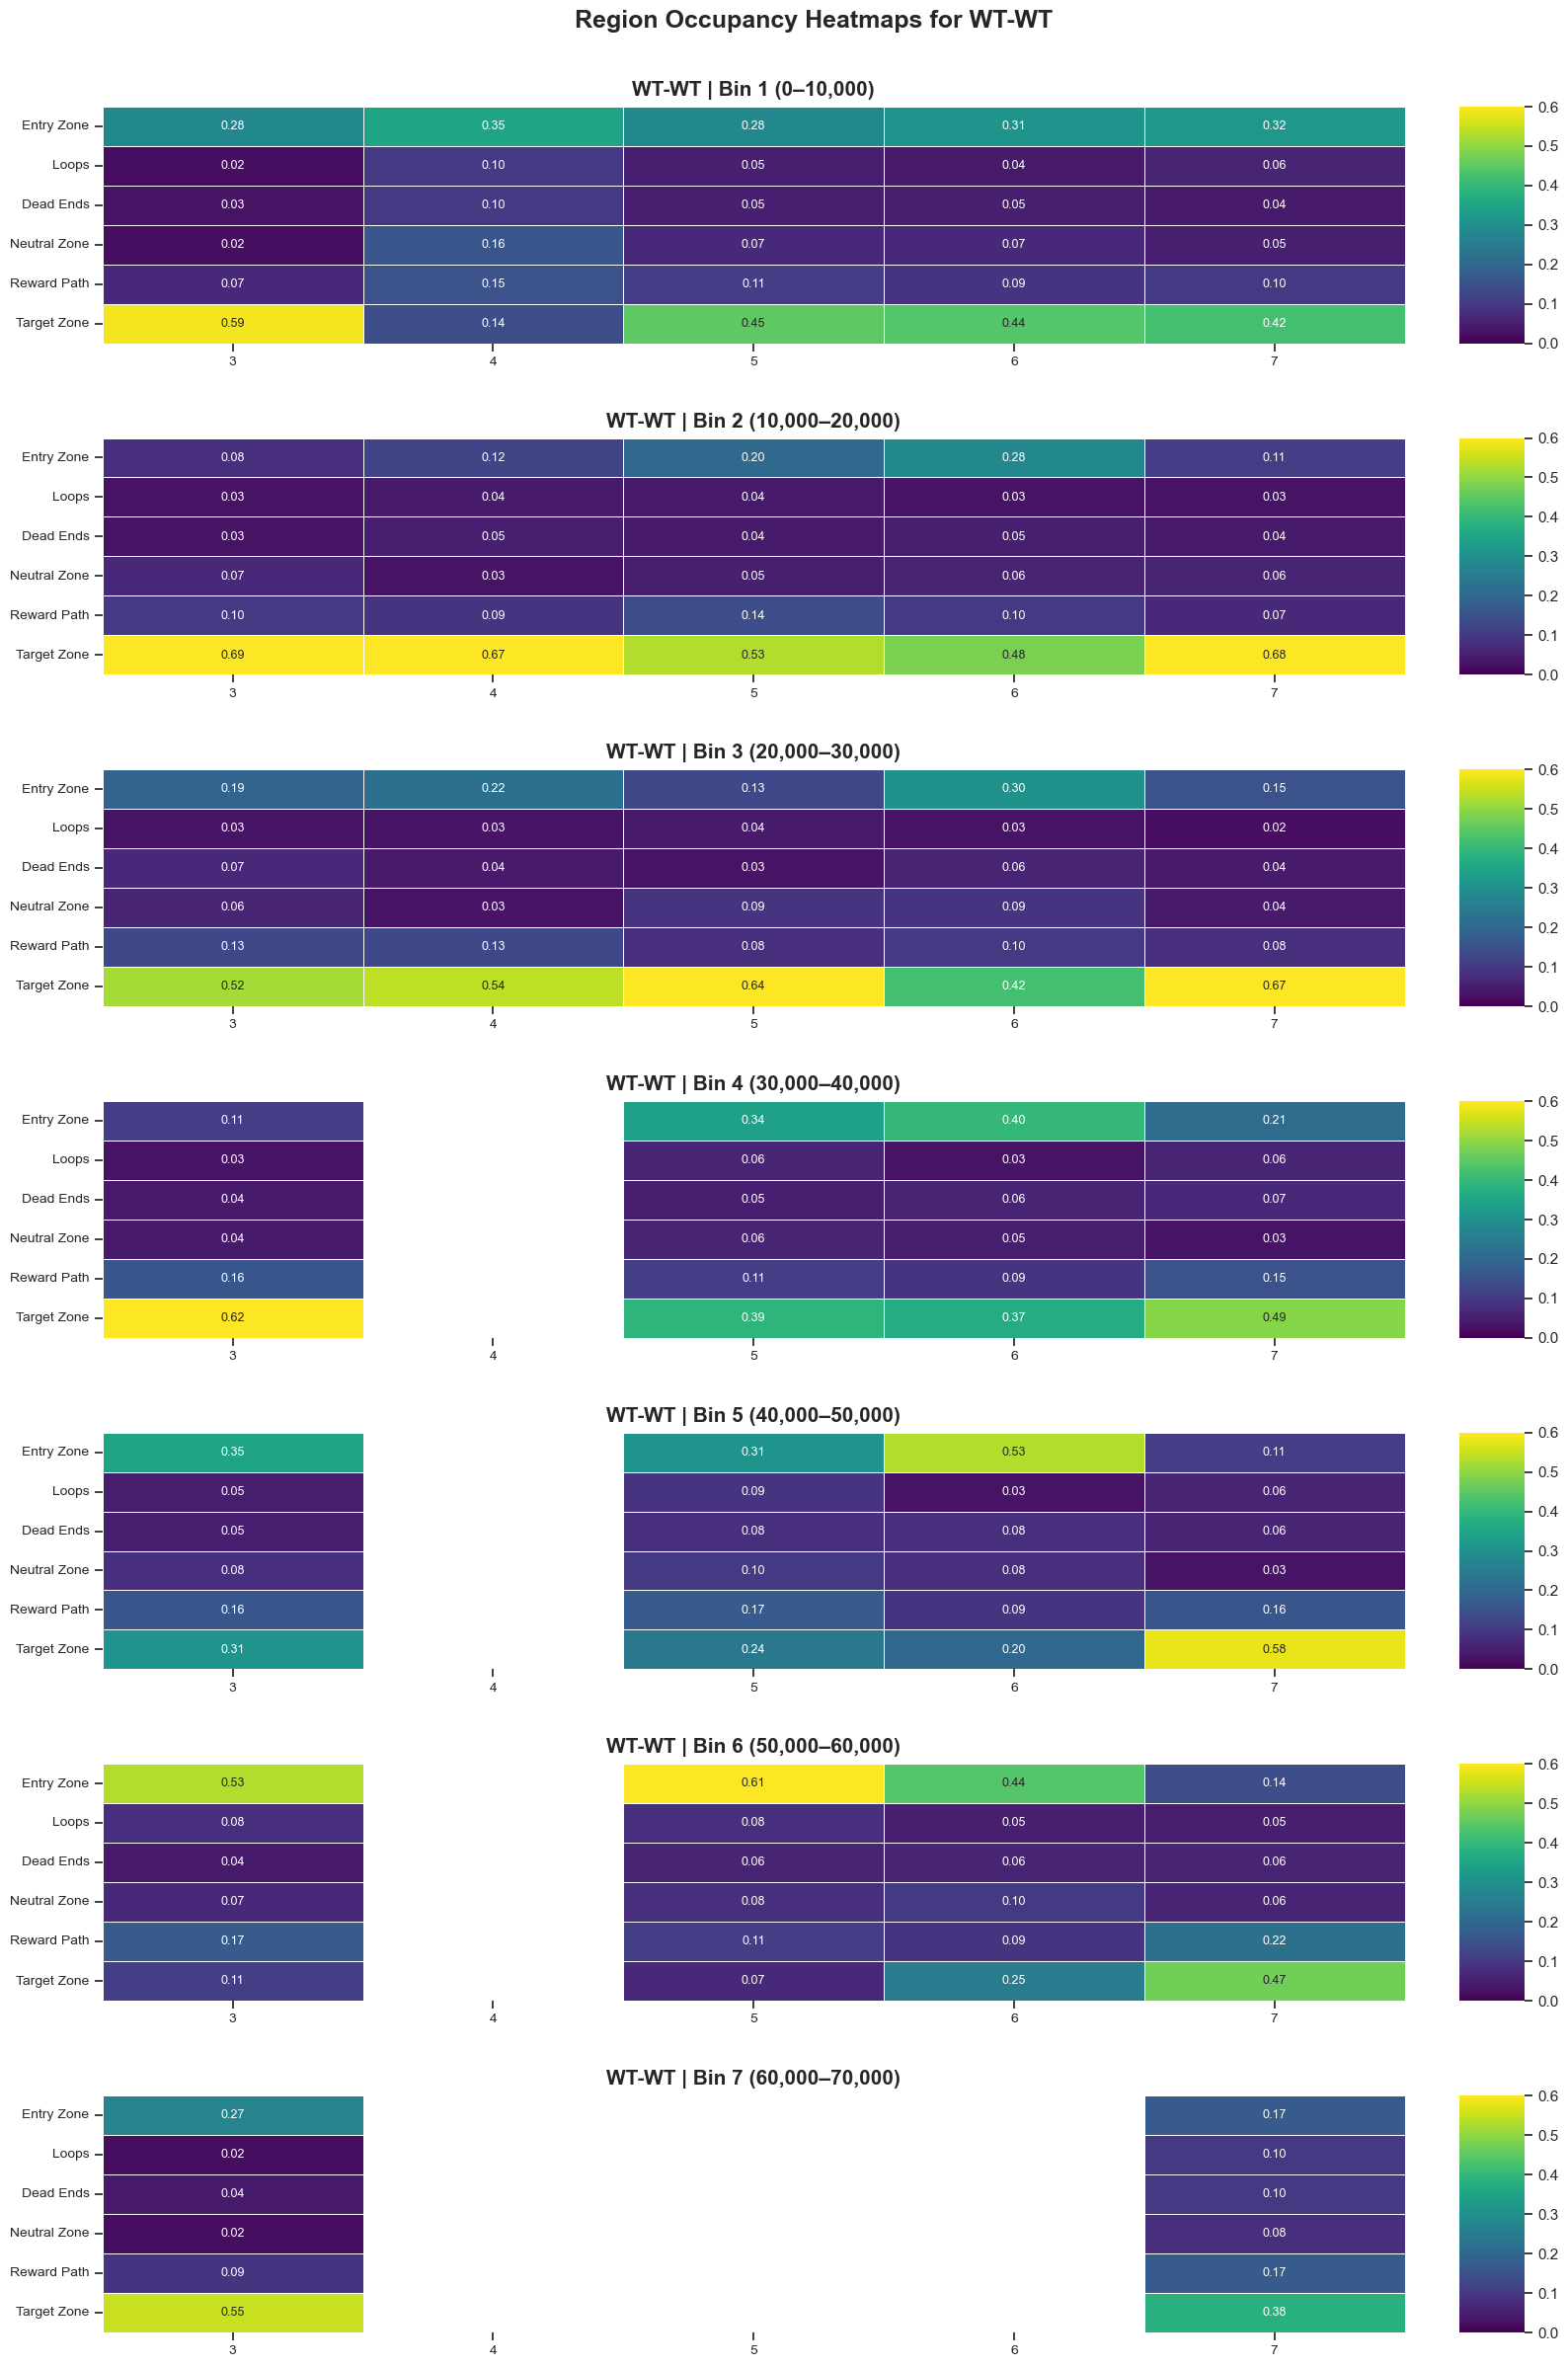

In [36]:
# =================== USAGE EXAMPLE =================== #

# Use this function to visualize how region occupancy evolves over time
# for a specific genotype or group in your behavioral dataset.
# Each heatmap corresponds to a fixed-length time bin and shows normalized
# region occupancy per session, allowing for temporal comparison.


# Recommended Use:
# ----------------

# 1. Ensure that `pivot_dict` is generated using `generate_region_heatmap_pivots()`.
# 2. Specify the genotype/group you want to plot (e.g., 'WT-WT').
# 3. Define the time binning parameters: `lower_lim`, `upper_lim`, and `difference`.
# 4. Optionally set a custom region order and vmax for consistent color scaling.
# 5. Run the function to display vertically stacked heatmaps across time bins.


# Example Workflow:
# -----------------

#-----------------------SET THESE VALUES---------------------#

GENOTYPE_DISP = 'WT-WT'
UPPER_LIMIT = get_max_session_row_bracket(df_all_csv) # upper limit for bins 
LOWER_LIMIT = 0 # lower limit for bins 
BIN_SIZE = 10000 # bin size for the heatmap plot
VMAX = 0.6 #Max. range on colorbar

#_________________________________________________________

# Store valid sessions post exclusion, specific to the genotype/group wanting to visualize
valid_sessions = df_all_csv[df_all_csv.Genotype == GENOTYPE_DISP]['Session'].unique().tolist()

# Plot the region-based heatmap
plot_region_heatmaps(
    pivot_dict=pivot_dict,
    group_name=GENOTYPE_DISP,
    lower_lim=LOWER_LIMIT,
    upper_lim=UPPER_LIMIT,
    difference=BIN_SIZE,
    vmax=VMAX,
    included_sessions=valid_sessions,
    region_desired_order=[
        'Entry Zone', 'Loops', 'Dead Ends', 
        'Neutral Zone', 'Reward Path', 'Target Zone'
    ]
)

# Save figure
save_figure(GENOTYPE_DISP+"_Heatmap_representation", subdir='results/task_performance', ext='pdf')

## EXTRA: Heatmap Representations across all Genotypes (when multiple genotypes)

In [ ]:
# #-----------------------SET THESE VALUES---------------------#

# included_genotypes = ['WT-WT'] # add more genotypes
# region_desired_order = ['Entry Zone', 'Loops', 'Dead Ends', 'Neutral Zone', 'Reward Path', 'Target Zone']
# UPPER_LIMIT = get_max_session_row_bracket(df_all_csv) # upper limit for bins 
# LOWER_LIMIT = 0 # lower limit for bins 
# BIN_SIZE = 10000 # bin size for the heatmap plot
# VMAX = 0.6 # Max. range on colorbar

# #_________________________________________________________

# plot_region_heatmaps_all_genotypes(
#     pivot_dict=pivot_dict,
#     df_all_csv=df_all_csv, 
#     lower_lim=LOWER_LIMIT,
#     upper_lim=UPPER_LIMIT,
#     difference=BIN_SIZE,
#     included_genotypes=included_genotypes,
#     region_desired_order=region_desired_order,
#     spacing_w=0.2,
#     spacing_h=0.15,
#     show_colorbar=True,
#     vmax=VMAX
# )

# # Save figure
# save_figure("AllGenotype_Heatmap_representation", subdir='results/task_performance', ext='pdf')

# Shannon's Entropy 

In [37]:
# =================== USAGE EXAMPLE =================== #

# This function calculates Shannon entropy over time, reflecting the diversity
# of region occupancy for each mouse/session within each time bin.
# A higher entropy indicates more distributed (less selective) region occupancy,
# whereas lower entropy suggests focused behavior within fewer regions.

# Recommended Use:
# -----------------
# 1. Ensure `pivot_dict` has been generated using `generate_region_heatmap_pivots()`.
# 2. Ensure `mouseinfo` includes metadata 


# Example Workflow:
# ----------------

# Compute entropy values
entropy_df = compute_shannon_entropy_per_bin(
    pivot_dict=pivot_dict, df_all_csv=df_all_csv,
    bin_size=BIN_SIZE # As used and specified in pivot_dict creation
)

## Plot 2: Plotting Shannon's Entropy across Sessions (/Mice)

Saved: c:\Users\PalopLabPortal\Gladstone Dropbox\Shreya Bangera\Labyrinth Mazes discussions\Code\TEST_COMPASS\results/task_performance\Shannons_entropy.pdf


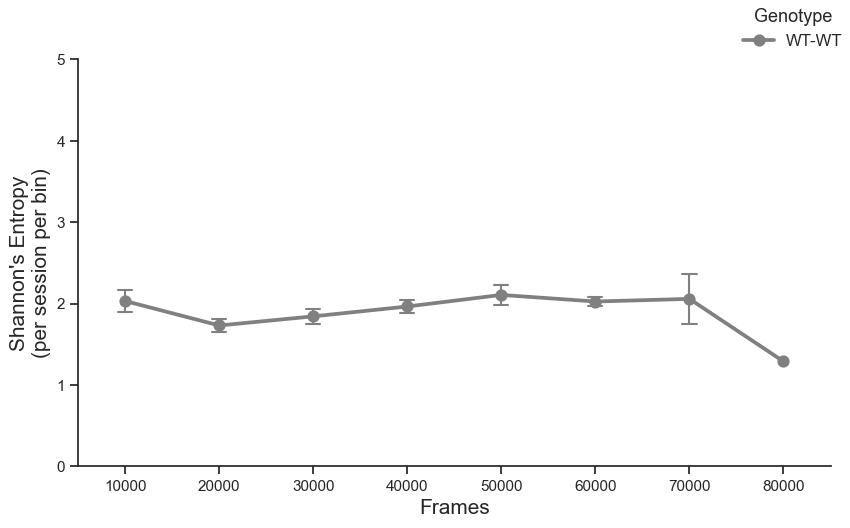

In [38]:
# Plot entropy over time
plot_entropy_over_bins(entropy_df, palette=PALETTE)

# Save figure
save_figure("Shannons_entropy", subdir='results/task_performance', ext='pdf')

### EXTRA: Statistical Tests

In [ ]:
# # Repeated Measures ANOVA
# anova_result = run_entropy_anova(entropy_df)

# # Pairwise t-tests + FDR correction (per bin, per genotype pair)
# fdr_results = run_fdr_pairwise_tests(entropy_df)
# print(fdr_results)

# # Run per-pair mixed models
# mixed_results, interaction_table = run_mixed_model_per_genotype_pair(entropy_df)

# # View pairwise Bin × Genotype interaction summary
# print(interaction_table)

# Proportion of Region-based usage across Time bins

In [39]:
# =================== USAGE EXAMPLE =================== #
# This function computes the proportion of usage of a specified region across
# sequential time bins, grouped by session and genotype, using the binned pivot tables.

# Recommended Use:
# ---------------
# 1. Ensure `pivot_dict` is the output from `generate_region_heatmap_pivots()` and contains binned region usage per genotype.
# 2. Use `mouseinfo` to map session IDs to genotypes for grouping.
# 3. Set `region` to the name of the region you want to evaluate (e.g., "Target Zone").
# 4. Set `bin_size` to match the time resolution used when generating `pivot_dict`.

# Example Workflow:
# -----------------

#--------------- SET THESE VALUES --------------#
REGION = "Target Zone"
BIN_SIZE = BIN_SIZE    # Based on pivot_dict

#________________________________________________________
# Compute region usage over time bins
reg_binned = compute_region_usage_over_bins(
    pivot_dict=pivot_dict,
    df_all_csv=df_all_csv,
    region=REGION,
    bin_size=BIN_SIZE
)


## Plot 3: Proportion of usage per Region across time

Saved: c:\Users\PalopLabPortal\Gladstone Dropbox\Shreya Bangera\Labyrinth Mazes discussions\Code\TEST_COMPASS\results/task_performance\Target Zone_prop_usage.pdf


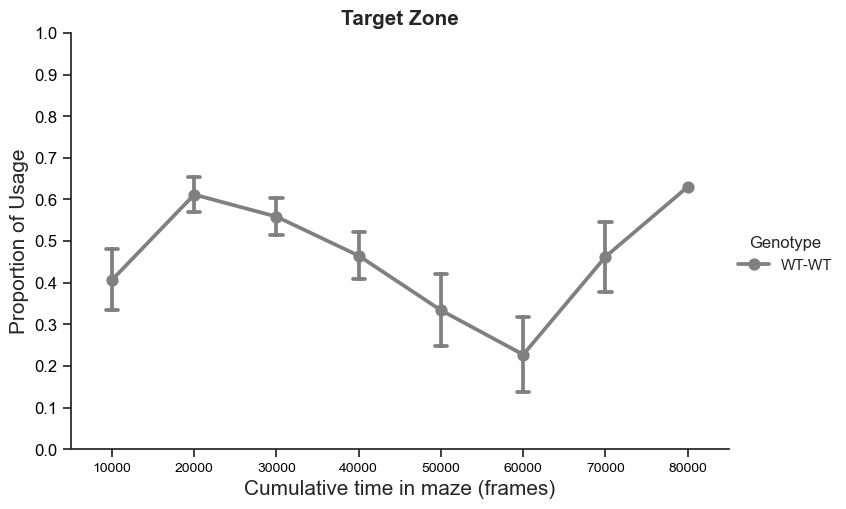

In [40]:
# Plot the region usage over time bins
plot_region_usage_over_bins(
    region_data=reg_binned,
    region_name=REGION,
    palette=PALETTE,
    ylim=(0, 1)
)

# Save figure
save_figure(REGION+"_prop_usage", subdir='results/task_performance', ext='pdf')

### EXTRA: Statistical Tests

In [ ]:
# # Run a Mixed Effects Model
# run_region_usage_stats_mixedlm(reg_binned, region_col=REGION)

# # Run pairwise comparison across genotypes with FDR correction
# run_region_usage_stats_fdr(reg_binned, region_col=REGION)

## Plot 4: Proportion of usage across all Regions

Saved: c:\Users\PalopLabPortal\Gladstone Dropbox\Shreya Bangera\Labyrinth Mazes discussions\Code\TEST_COMPASS\results/task_performance\AllRegions_prop_usage.pdf


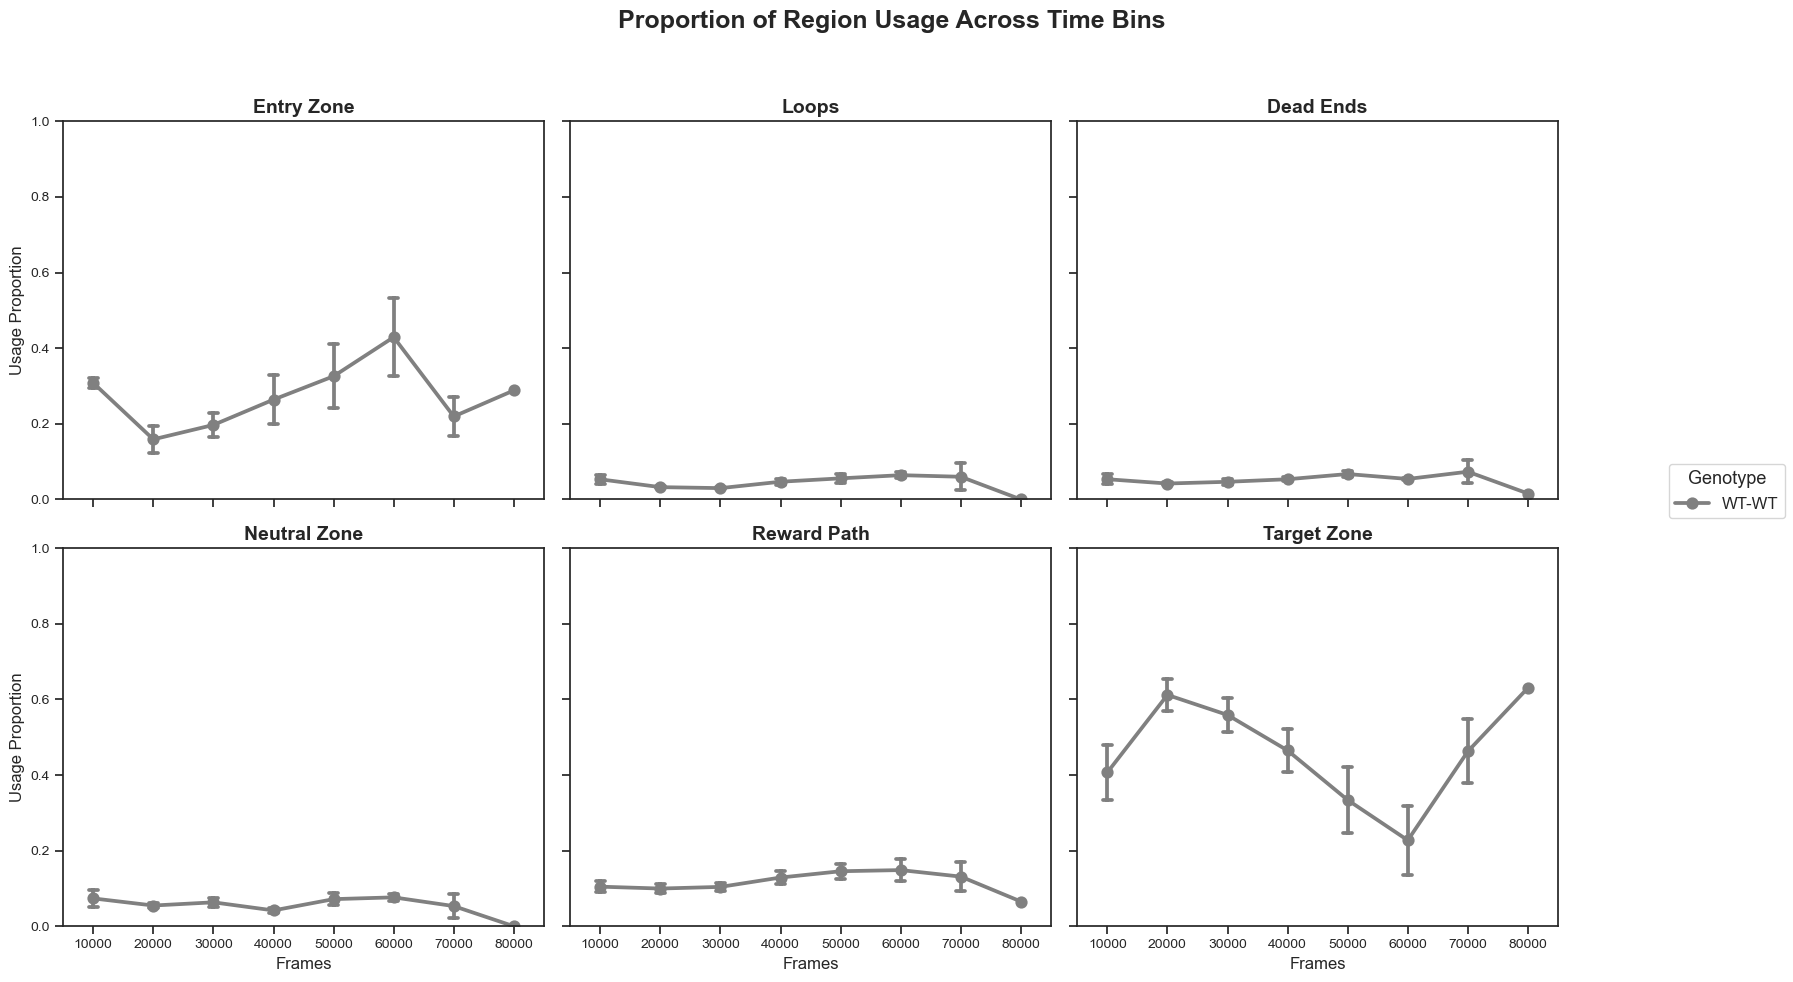

In [41]:
# Plot usage over time bins for all Regions 

#--------------- SET THESE VALUES --------------#
region_list = ['Entry Zone', 'Loops','Dead Ends', 'Neutral Zone', 'Reward Path', 'Target Zone']


#_____________________________________________________
plot_all_regions_usage_over_bins(
    pivot_dict,
    df_all_csv,
    region_list=region_list,
    bin_size=BIN_SIZE,
    palette=PALETTE,
    ylim=(0, 1)
)

# Save figure
save_figure("AllRegions_prop_usage", subdir='results/task_performance', ext='pdf')

# Bout-Level Success Metrics

## Plot 5: Cumulative Successful Bout Percentage

In [336]:
# A bout is defined as a continuous sequence starting from the Entry Zone, 
# passing through non-entry nodes, and returning to the Entry Zone. 

# A successful bout is defined as one in which the animal reaches the Target Zone
# at least once before returning to the Entry Zone.

Saved: c:\Users\PalopLabPortal\Gladstone Dropbox\Shreya Bangera\Labyrinth Mazes discussions\Code\TEST_COMPASS\results/task_performance\Cumulative_successful_bouts.pdf


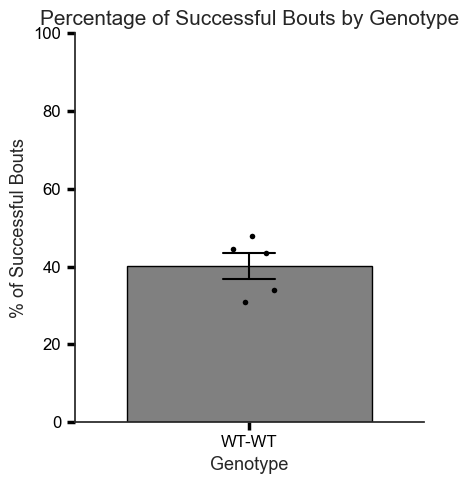

In [42]:
# 1. Assign bout indices to the navigation dataframe
df_all_csv_wbouts = assign_bout_indices_from_entry_node(df_all_csv)

# 2. Compute success summary statistics
bout_summary = summarize_bout_success_by_session(df_all_csv_wbouts)

# 3. Plot % of successful bouts per genotype
plot_success_rate(bout_summary, palette=PALETTE)

# Save figure
save_figure("Cumulative_successful_bouts", subdir='results/task_performance', ext='pdf')


### EXTRA: Statistical Tests

In [ ]:
# # Perform t-test on Success Rate
# ttest_results_success = perform_genotype_ttests(bout_summary, rate_col='Success_Rate')
# print("T-Test on Success Rate:")
# for k, v in ttest_results_success.items():
#     print(f"{k}: t={v['t_stat']:.3f}, p={v['p_value']:.4f}, mean1={v['mean_1']:.2f}, mean2={v['mean_2']:.2f}")

## Plot 6: Time-based Successful Bout Percentage

In [44]:
# =================== USAGE EXAMPLE =================== #
# This function computes the percentage of successful bouts within sequential time bins
# across all sessions, allowing time-resolved assessment of goal-directed behavior.

# Recommended Use:
# ---------------
# 1. Ensure `df_all_csv` includes 'Session', 'Grid.Number', 'Bout_Index', and time-ordered rows.
# 2. Set `lower_succ_lim` and `upper_succ_lim` to define the full range of timepoints to analyze.
# 3. Set `diff_succ` as the size of each time bin (e.g., 5000).
# 4. Use `valid_bout_threshold` to exclude short bouts (e.g., < 19 steps).
# 5. Set `optimal_path_regions` to define which regions are required for optimal navigation.
# 6. Set `target_zone` to specify the region that marks a successful bout.

# Example Workflow:
# -----------------

#--------------- SET THESE VALUES --------------#
BIN_SIZE = 5000
LOWER_BOUND = 0
UPPER_BOUND = 90000

#________________________________________________________
summary_df = compute_binned_success_summary(
    df_all_csv_wbouts,
    lower_succ_lim=LOWER_BOUND,
    upper_succ_lim=UPPER_BOUND,
    diff_succ=BIN_SIZE,
    valid_bout_threshold=19,
    optimal_path_regions=['Entry Zone', 'Reward Path', 'Target Zone'],
    target_zone='Target Zone'
)


Saved: c:\Users\PalopLabPortal\Gladstone Dropbox\Shreya Bangera\Labyrinth Mazes discussions\Code\TEST_COMPASS\results/task_performance\Time_based_successful_bouts.pdf


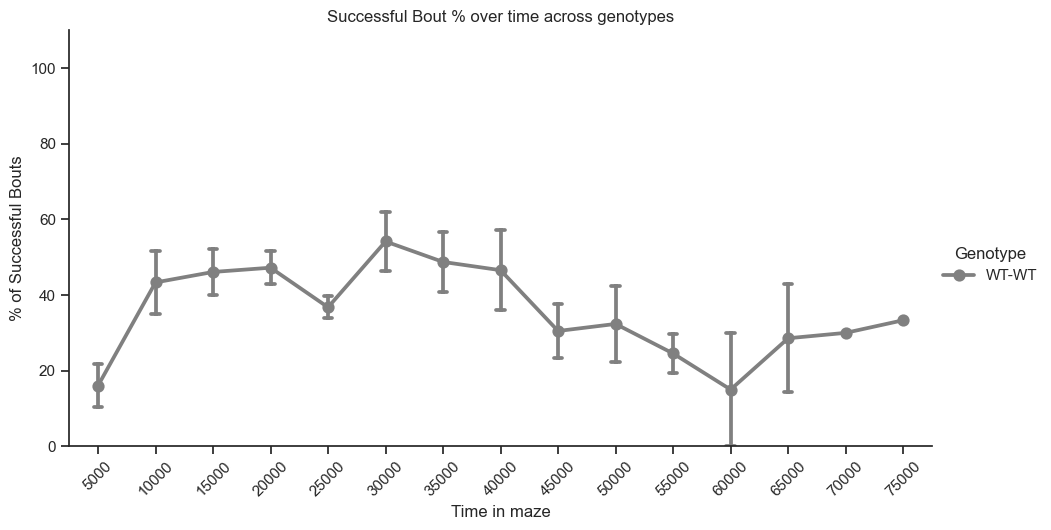

In [45]:
# Visualize the percentage of successful bouts within each time bin,

plot_binned_success(summary_df, palette=PALETTE)

# Save figure
save_figure("Time_based_successful_bouts", subdir='results/task_performance', ext='pdf')


### EXTRA: Statistical Tests

In [ ]:
# # Run Mixed Linear Model (preserves NaNs)
# run_mixedlm_with_nans(summary_df)

# # Run Repeated Measures ANOVA (NaNs filled with 0)
# run_repeated_measures_anova(summary_df)

# # Run Pairwise Comparisons (with FDR correction)
# run_pairwise_comparisons(summary_df)


# Plot 6: Deviation from Reward Path and Velocity

In [ ]:
# =================== USAGE EXAMPLE =================== #
# This function filters, normalizes, and smooths deviation and velocity values
# for the specified genotype, and fits exponential curves to the processed data.

# Recommended Use:
# ---------------
# 1. Ensure `df_deviation` includes 'Ind_no', 'Genotype', 'Deviation', and 'Velocity' columns.
# 2. Set `genotype` to filter the group of interest (e.g., 'WT-WT').

# Example Workflow:
# -----------------

#--------------- SET THIS VALUE --------------#
GENOTYPE = 'WT-WT'

#________________________________________________________

# Ensures velocity column exists
df_all_csv_wvelocity = ensure_velocity_column(df_all_csv, x_col='x', y_col='y', frame_rate=5.0)

# Ensure Bout Index column Bout_ID exists
df_all_csv_wbouts = ensure_bout_indices(df_all_csv_wvelocity, delimiter_node= 47)

# Compute deviation and velocity per bout
df_deviation = compute_deviation_velocity(df_all_csv_wbouts)

# Process deviation and velocity (normalize, smooth, fit curves)
df_processed, params_dev, params_vel = process_deviation_velocity(df_deviation, genotype=GENOTYPE)


Saved: c:\Users\PalopLabPortal\Gladstone Dropbox\Shreya Bangera\Labyrinth Mazes discussions\Code\TEST_COMPASS\results/task_performance\WT-WT_Deviation_Velocity_metric.pdf


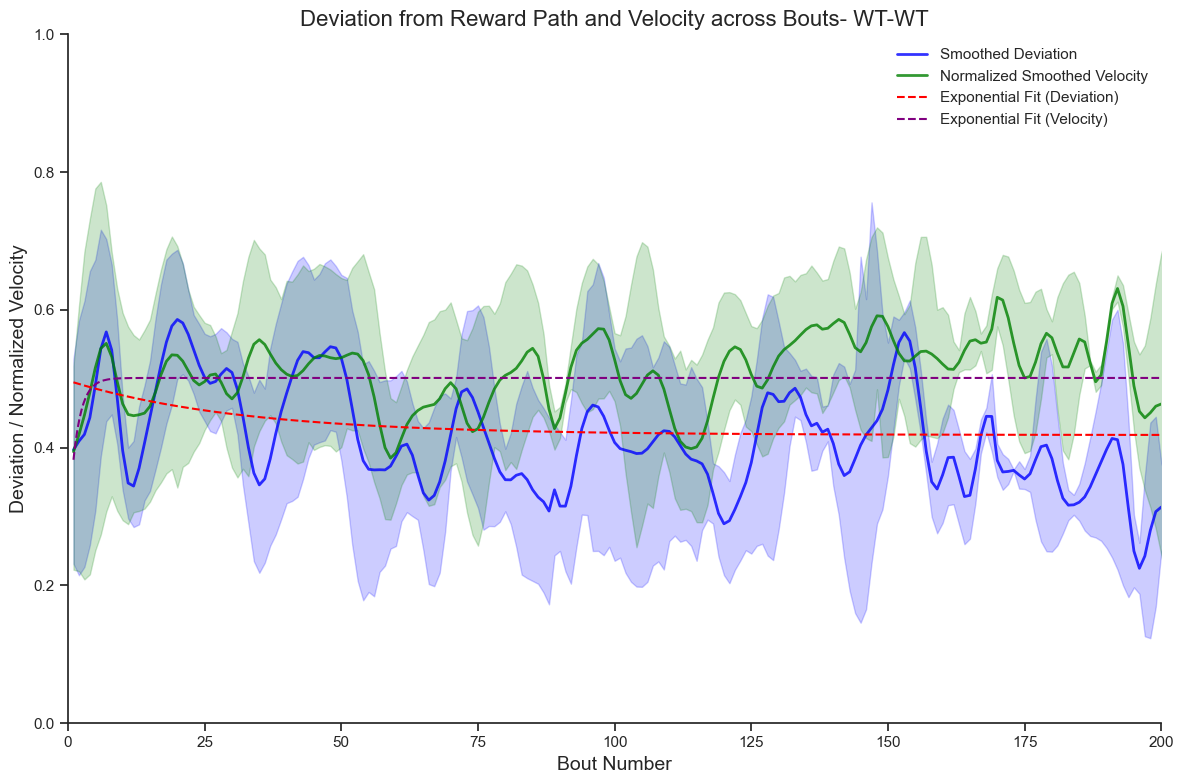

In [55]:
# Plots smoothed deviation and normalized velocity trajectories across bouts, overlaid with exponential fit curves
plot_deviation_velocity_fit(df_processed, params_dev, params_vel, genotype=GENOTYPE, max_bouts=200)

# Save figure
save_figure(GENOTYPE+"_Deviation_Velocity_metric", subdir='results/task_performance', ext='pdf')

## EXTRA: Deviation from Reward Path and Velocity for all Genotypes

In [ ]:
# # Compute deviation and velocity per bout
# df_deviation = compute_deviation_velocity(df_all_csv)

# # Plot Deviation-Velocity plots for all genotypes
# plot_deviation_velocity_all(df_deviation, max_bouts=200)

# # Save figure
# save_figure("AllGenotype_Deviation_Velocity_metric", subdir='results/task_performance', ext='pdf')